DESCRIPTION: Run population estimations of a country based on various assumptions.

# Demographics

In [56]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)

In [50]:
'''
Columns:
  NAME: The name of the country
  GENC: Geography, the country abbreviation
  POP: The population
  SEX:
    0 = Both genders
    1 = Male
    2 = Female

  
'''
url = "https://api.census.gov/data/timeseries/idb/1year?get=NAME,GENC,POP&YR=2023,2024&AGE=0:100&SEX=0,1,2"
df = pd.read_json(url)
df

,0,1,2,3,4,5
0,NAME,GENC,POP,YR,AGE,SEX
1,Andorra,AD,586,2023,0,0
2,Andorra,AD,302,2023,0,1
3,Andorra,AD,284,2023,0,2
4,Andorra,AD,588,2023,1,0
...,...,...,...,...,...,...
137558,United Arab Emirates,AE,7,2024,99,1
137559,United Arab Emirates,AE,11,2024,99,2
137560,United Arab Emirates,AE,34,2024,100,0
137561,United Arab Emirates,AE,15,2024,100,1


In [51]:
# Rename the columns
df = df.rename(columns={0: 'Country', 1: 'Abbr', 2: 'Population', 3: 'Year', 4: 'Age', 5: 'Sex'})

# Drop the first row
df = df.iloc[1:, :]

# Convert string columns to integers
df["Population"] = df["Population"].astype(int)
df["Age"] = df["Age"].astype(int)
df["Sex"] = df["Sex"].astype(int)

df

,Country,Abbr,Population,Year,Age,Sex
1,Andorra,AD,586,2023,0,0
2,Andorra,AD,302,2023,0,1
3,Andorra,AD,284,2023,0,2
4,Andorra,AD,588,2023,1,0
5,Andorra,AD,303,2023,1,1
...,...,...,...,...,...,...
137558,United Arab Emirates,AE,7,2024,99,1
137559,United Arab Emirates,AE,11,2024,99,2
137560,United Arab Emirates,AE,34,2024,100,0
137561,United Arab Emirates,AE,15,2024,100,1


In [52]:
c = df.copy(True)

country = "China"
ctry = 'CN'

# Filter rows for a specific country
c = c[(c['Abbr'] == ctry) & (c['Year'] == '2023')]

# Total for country
print(f"Total population for {country} = {c['Population'].sum():,.0f}")

# Add a calculated rows. We'll split the "Both Genders" population evenly between males and females.
c['Males'] = (c.Population * (c.Sex == 1) + c.Population/2 * (c.Sex == 0)).astype(int)
c['Females'] = (c.Population * (c.Sex == 2) + c.Population/2 * (c.Sex == 0)).astype(int)

c

Total population for China = 2,826,285,692


,Country,Abbr,Population,Year,Age,Sex,Males,Females
12424,China,CN,13760508,2023,0,0,6880254,6880254
12425,China,CN,7194194,2023,0,1,7194194,0
12426,China,CN,6566314,2023,0,2,0,6566314
12427,China,CN,14379462,2023,1,0,7189731,7189731
12428,China,CN,7540282,2023,1,1,7540282,0
...,...,...,...,...,...,...,...,...
12722,China,CN,15484,2023,99,1,15484,0
12723,China,CN,44974,2023,99,2,0,44974
12724,China,CN,87422,2023,100,0,43711,43711
12725,China,CN,20664,2023,100,1,20664,0


In [63]:
# Group the populations into age ranges; 0-5, 6-10, 11-15, ...

bins = np.arange(0, 120, 5)
#print(bins)
d = c.groupby(pd.cut(df["Age"], bins)).sum()
d

,Population,Age,Sex,Males,Females
Age,,,,,
"(0, 5]",144746666,45,15,74357278,70389387
"(5, 10]",162605998,120,15,84109956,78496039
"(10, 15]",162875042,195,15,84692201,78182840
"(15, 20]",149852834,270,15,77861117,71991714
"(20, 25]",160260894,345,15,82993873,77267020
"(25, 30]",194156600,420,15,99763283,94393315
"(30, 35]",244543024,495,15,123724691,120818331
"(35, 40]",212443778,570,15,107474467,104969308
"(40, 45]",192111578,645,15,97088863,95022712


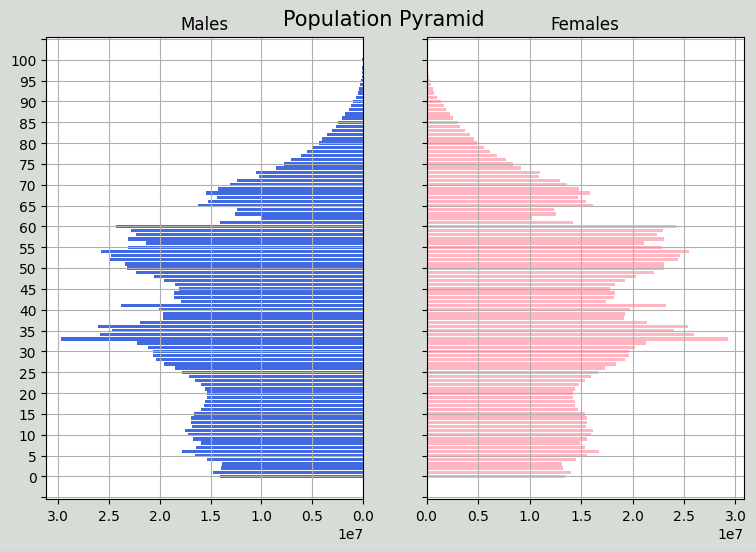

In [75]:
# Plot it as a pyramid graph
from matplotlib.ticker import MultipleLocator

DF = c.groupby(df['Age']).sum().copy()
y = range(0, len(DF.index))
x_male = DF['Males']
x_female = DF['Females']

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 6))
fig.patch.set_facecolor('xkcd:light grey')
plt.figtext(.5,.9,"Population Pyramid", fontsize=15, ha='center')

axes[0].barh(y, x_male, align='center', color='royalblue')
axes[0].set(title='Males')
axes[1].barh(y, x_female, align='center', color='lightpink')
axes[1].set(title='Females')
axes[1].grid()

axes[0].set(yticks=y, yticklabels=DF.index)
axes[0].yaxis.set_major_locator(MultipleLocator(5))
axes[0].invert_xaxis()
axes[0].grid()

plt.show()